# Aumento de data

Se hará uso de Tensorflow y el arreglo de estilo "n-gram" para crear nuevas cadenas de texto a partir del entrenamiento
y predicción de un modelo que permita generar una palabra a partir de sus anteriores.

Fuente: https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

In [1]:
# Importar librerías necesarias. 

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import random
import numpy as np
from random import randrange, choice
import pickle
import nltk 
stopwords = nltk.corpus.stopwords.words('english')

In [3]:
# Carga de la data

Flagged_basic = pickle.load(open("./data_final/Flagged_basic.p", "rb" ))
Flagged_GloVe = pickle.load(open("./data_final/Flagged_GloVe.p", "rb" ))

Flagged = Flagged_basic + Flagged_GloVe

In [6]:
#Se carga el tokenizador de la librería Keras y se entrena con el corpus 
# para generar un diccionario de cada una de las palabras con su respectiva representación numérica.

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(Flagged)
word_index = tokenizer.word_index

total_words = len(word_index) + 1 

print(tokenizer.word_index)
print(" \n Cantidad de palabras diferentes:",  total_words)

{'i': 1, 'be': 2, 'and': 3, 'to': 4, 'she': 5, 'go': 6, 'he': 7, 'a': 8, 'have': 9, 'my': 10, 'help': 11, 'the': 12, 'with': 13, 'talk': 14, 'of': 15, 'depression': 16, 'for': 17, 'get': 18, 'in': 19, 'anxiety': 20, 'that': 21, 'try': 22, 'would': 23, 'as': 24, 'when': 25, 'it': 26, 'good': 27, 'through': 28, 'her': 29, 'but': 30, 'make': 31, 'year': 32, 'issue': 33, 'think': 34, 'deal': 35, 'life': 36, 'one': 37, 'use': 38, 'addiction': 39, 'everything': 40, 'find': 41, 'out': 42, 'some': 43, 'they': 44, 'though': 45, 'well': 46, 'back': 47, 'severe': 48, 'ex': 49, 'diagnose': 50, 'kill': 51, 'there': 52, 'not': 53, 'this': 54, 'on': 55, 'will': 56, 'need': 57, 'person': 58, 'call': 59, 'suicide': 60, 'what': 61, 'say': 62, 'simply': 63, 'support': 64, 'know': 65, 'come': 66, 'school': 67, 'comfort': 68, 'night': 69, 'see': 70, 'could': 71, 'time': 72, 'desire': 73, 'much': 74, 'want': 75, 'end': 76, 'disorder': 77, 'start': 78, 'look': 79, 'feel': 80, 'shit': 81, 'experience': 82, 'm

In [9]:
# Creación de las secuencias de entrada de la red neuronal 
## con oraciones del set de datos, las cuales serán convertidas en secuencias de números 
## en un arreglo de estilo n-gram

input_sequences = []

for line in Flagged:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# Conocer la longitud máxima para igualar las cadenas a la más larga.

max_sequence_len = max([len(x) for x in input_sequences])

# Completar las cadenas cortas a la más larga con el "padding"
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Separación de objetivo y predictoras según el último término del input_sequences para "Y"" y el resto para "X"
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [10]:
model = Sequential()
model.add(Embedding(total_words, 240, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 240)           88800     
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           469200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 17, 300)           541200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 185)               18685     
_________________________________________________________________
dense_1 (Dense)              (None, 370)              

In [12]:
class myCallback(tf.keras.callbacks.Callback):
      
      def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')> 0.85):
                  print("\nReached 85% accuracy so cancelling training!")
                  self.model.stop_training = True

callbacks = myCallback()

In [13]:
history = model.fit(predictors, label, batch_size=10, epochs=200, verbose=1, callbacks=[callbacks])

Epoch 1/200
165/165 [==============================] - 14s 41ms/step - loss: 6.2151 - accuracy: 0.0292
Epoch 2/200
165/165 [==============================] - 10s 59ms/step - loss: 5.5930 - accuracy: 0.0365
Epoch 3/200
165/165 [==============================] - 10s 60ms/step - loss: 5.4169 - accuracy: 0.0316
Epoch 4/200
165/165 [==============================] - 10s 60ms/step - loss: 5.2954 - accuracy: 0.0328
Epoch 5/200
165/165 [==============================] - 9s 56ms/step - loss: 5.2211 - accuracy: 0.0310
Epoch 6/200
165/165 [==============================] - 9s 52ms/step - loss: 5.1250 - accuracy: 0.0377
Epoch 7/200
165/165 [==============================] - 10s 58ms/step - loss: 5.0204 - accuracy: 0.0383
Epoch 8/200
165/165 [==============================] - 9s 57ms/step - loss: 4.9353 - accuracy: 0.0359
Epoch 9/200
165/165 [==============================] - 9s 53ms/step - loss: 4.8611 - accuracy: 0.0383
Epoch 10/200
165/165 [==============================] - 9s 53ms/step - loss: 

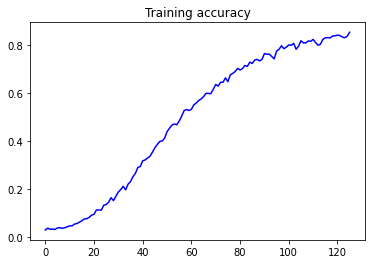

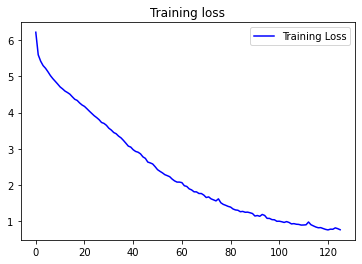

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

#grafica #2
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()

#grafica #1
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [19]:
# Creación de una bolsa de palabras para elegir dos términos de manera aleatoria 
## que permitan dar inicio a las cadenas de texto.

word_list = [key for key in word_index.keys() if key not in stopwords]

# Creación de las variables que nos permitirán escoger al azar un numero 
## según una distribución probabilística normal
mess_range = 500 - len(Flagged)
mu, sigma = 8, 1

In [20]:
# Generación de las nuevas cadenas a partir de la secuencia de terminos anterior.

LSTM_temp = []

for _ in range(mess_range):
  text = ""
  text = choice(word_list) # Elección de número aleatorio de longitud
  text = text + ' ' + choice(word_list)
  words_qt =  int(random.gauss(mu, sigma))

  for _ in range(words_qt):
    token_list = tokenizer.texts_to_sequences([text])[0] #conversión del texto inicial en secuencia.
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  
    predicted = np.argmax(model.predict(token_list), axis=-1) #predicción a partir de la entrada transformada de los tokens
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    text += " " + output_word
  LSTM_temp.append(text)

In [24]:
LSTM_temp[:15]

['calm find kindness of her personal problem cope focus',
 'reality life loss of girl get catch bedroom slowly die',
 'suffer parent get last mental health father give support my experience',
 'human trouble start date feel the relationship start suffer quite',
 'look drive light lack support family hospital number know',
 'hold way simply talk would try change it be',
 'throughout big addiction issue i some a hospital',
 'several half be one support result quite severe a',
 'problem else have her mental switch on my',
 'sometime use hear due early mind from year early good',
 'part douche would like would have depression make in',
 'high die inside mind kindness go through depression and',
 'drug last past switch on want year',
 'cop anything get bedroom all need sometime like',
 'catch anniversary weed pill talk would answer even though']

In [25]:
pickle.dump(LSTM_temp, open("./data_final/Flagged_LSTM.p", "wb" ))